## Deep Learning training with LSTM and an extended FastText word embedding
We test here the combination of:
* an embedding layer which is initialized with a pretrained fasttext word embedding extended with custom embedding model
* a LTSM layer to capture word sequence representation
* a dense layer to learn classification

We leverage the pre-trained fasttext word embedding model gracefully supplied by Facebook company at [https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md)

This general purpose word embedding model is extended with custom model generated by [fasttext_embedding_extension_builder.ipynb](fasttext_embedding_extension_builder.ipynb) script

In [53]:
import numpy as np
import pandas as pd
embeddings_index = {}

In [54]:
from sklearn.model_selection import train_test_split

XTrain = pd.read_csv('../../data/staging_data/mispelling_fixed_clean_input_train.csv', sep=',')
YTrain = pd.read_csv('../../data/POSOS/label.csv', sep=';')

XTrain, XTest, YTrain, YTest = train_test_split(XTrain, YTrain, test_size=0.15, random_state=42)


###  <b>Build neural network with LSTM and FastText embedding<b>

In [55]:
# hyper-parameters
num_classes = 51
vocabulary_size = 10000
sequence_length = 30
embedding_out_dims = 300
dropout_ratio = 0.15
num_epochs = 100
hidden_dims = 200
patience = 20

In [56]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(XTrain['question'])

sequences = tokenizer.texts_to_sequences(XTrain['question'])
XEncodedTrain = pad_sequences(sequences, maxlen=sequence_length, truncating='pre')

In [57]:
# load the French fasttext model
import os, re, csv, math, codecs
from tqdm import tqdm

embeddings_index = {}

if len(embeddings_index) == 0:
    
    f = codecs.open('../../pretrained_models/fasttext/wiki.fr.vec', encoding='utf-8')
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

1152466it [02:31, 7632.01it/s]


In [58]:
# %load ../utils/serializer.py

import csv

def saveEmbeddingVector(vectors, fileName):
    ''' save a dict of numerical array'''
    with open(fileName, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in vectors.items():
            writer.writerow([key, ",".join([str(i) for i in value])])
    csv_file.close()

def loadEmbeddingVector(fileName):
    ''' load a dict of numerical array'''
    with open(fileName, 'r') as csv_file:
        reader = csv.reader(csv_file);
        temp_dict = dict(reader)
        myDict={k:list(map(lambda x: float(x), v.split(','))) for k,v in temp_dict.items()}    
        csv_file.close()
        return myDict 
    return None

In [59]:
# complete the embedding mode with the custom one built by the script additional_fasttext_embedding_builder.ipynb
customEmbedding = loadEmbeddingVector('../../pretrained_models/fasttext_embedding_extension.txt')

for k,v in customEmbedding.items():
    embeddings_index[k] = v    

In [60]:
nb_words = min(vocabulary_size, len(tokenizer.word_index))

embedding_matrix = np.zeros((nb_words+1, embedding_out_dims))

for word, i in tokenizer.word_index.items():
    if i >= nb_words:
        continue
                
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        raise Exception("unknown word=" + word)

In [61]:
import tensorflow as tf
import keras
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional
#config = tf.ConfigProto(device_count={"CPU": 32})

# configure tensorflow
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)
config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True)
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

# build neural network
model_lstm = Sequential()

# dimension reduction layer
model_lstm.add(
    Embedding(
        len(tokenizer.word_index)+1,
        embedding_out_dims,
        weights=[embedding_matrix],
        input_length=sequence_length,
        trainable=False))

# recurrent network layer
model_lstm.add(Bidirectional(CuDNNLSTM(embedding_out_dims)))

# classification hidden layer
model_lstm.add(Dense(hidden_dims, activation="relu"))

# random node inactivation
model_lstm.add(Dropout(dropout_ratio))

# normalization layer
model_lstm.add(Dense(num_classes, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 30, 300)           2437200   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 600)               1444800   
_________________________________________________________________
dense_17 (Dense)             (None, 200)               120200    
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 51)                10251     
Total params: 4,012,451
Trainable params: 1,575,251
Non-trainable params: 2,437,200
_________________________________________________________________


import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from keras.utils.vis_utils import plot_model
plot_model(model_lstm, to_file='c:/Users/I051796/Projects/CES/report/model.png', show_shapes=True)

#pd.DataFrame(XEncodedTrain).to_csv('c:/Users/I051796/Projects/CES/notebooks/XEncodedTrain.txt', index=False, header=False)
XEncodedTrain = pd.read_csv('c:/Users/I051796/Projects/CES/notebooks/XEncodedTrain.txt', header=None)
XEncodedTrain = XEncodedTrain.values
XEncodedTrain.shape

### Train the network

In [62]:
YOneHotEncodedTrain = keras.utils.to_categorical(YTrain['intention'])

In [63]:
# generate the tensorflow board
call_back_board = keras.callbacks.TensorBoard(
    log_dir='c:/git/CES/logs',
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    write_grads=True,
    write_images=True,
    embeddings_freq=0,
    embeddings_layer_names=None,
    embeddings_metadata=None,
    embeddings_data=None)

# stop criterion to avoid overfitting
call_back_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=patience,
    verbose=0,
    mode='auto',
    baseline=None)

# learn !
model_lstm.fit(
    XEncodedTrain,
    np.array(YOneHotEncodedTrain),
    validation_split=0.10,
    epochs=num_epochs,
    verbose=2,
    callbacks = [call_back_early_stopping, call_back_board])
pass

Train on 6140 samples, validate on 683 samples
Epoch 1/100
 - 8s - loss: 2.7429 - acc: 0.3142 - val_loss: 2.3414 - val_acc: 0.4012
Epoch 2/100
 - 6s - loss: 1.8916 - acc: 0.5023 - val_loss: 1.9556 - val_acc: 0.4963
Epoch 3/100
 - 6s - loss: 1.4017 - acc: 0.6192 - val_loss: 1.6688 - val_acc: 0.5549
Epoch 4/100
 - 6s - loss: 1.0664 - acc: 0.6928 - val_loss: 1.5686 - val_acc: 0.5842
Epoch 5/100
 - 7s - loss: 0.8518 - acc: 0.7498 - val_loss: 1.6108 - val_acc: 0.5974
Epoch 6/100
 - 6s - loss: 0.6487 - acc: 0.8046 - val_loss: 1.5710 - val_acc: 0.6325
Epoch 7/100
 - 6s - loss: 0.4840 - acc: 0.8542 - val_loss: 1.6712 - val_acc: 0.6047
Epoch 8/100
 - 6s - loss: 0.3567 - acc: 0.8945 - val_loss: 1.7256 - val_acc: 0.6354
Epoch 9/100
 - 6s - loss: 0.2724 - acc: 0.9173 - val_loss: 1.8642 - val_acc: 0.6120
Epoch 10/100
 - 6s - loss: 0.1825 - acc: 0.9484 - val_loss: 1.9648 - val_acc: 0.6135
Epoch 11/100
 - 6s - loss: 0.1733 - acc: 0.9505 - val_loss: 1.9425 - val_acc: 0.6252
Epoch 12/100
 - 6s - loss: 

In [64]:
# %load ../utils/vizu.py
import matplotlib.pyplot as plt
import itertools

def plot_keras_model_learning_curve(history):
    ''' plot accuracy of the Keras model on training and validation set '''
    plt.figure(figsize=(12,8))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

    plt.xlabel('Predicted label')

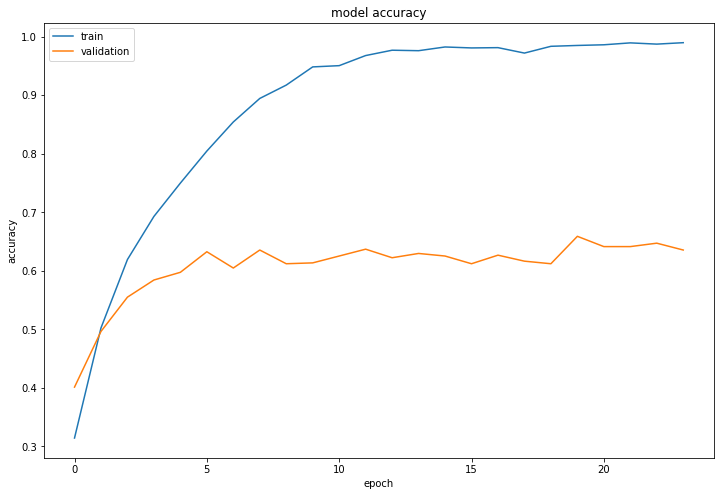

In [65]:
%matplotlib inline
plot_keras_model_learning_curve(model_lstm.history)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.79      0.43      0.56        35
          1       0.00      0.00      0.00         4
          2       1.00      0.40      0.57         5
          3       0.50      1.00      0.67         1
          4       0.80      0.73      0.76        11
          5       0.31      0.28      0.29        18
          6       0.43      0.75      0.55         4
          7       0.00      0.00      0.00         1
          8       0.74      0.68      0.71        25
          9       0.50      0.43      0.46         7
         10       0.67      0.33      0.44        12
         11       0.44      0.52      0.47        27
         12       0.14      0.33      0.20         6
         13       0.28      0.42      0.33        12
         14       0.31      0.38      0.34        42
         15       1.00      0.50      0.67         4
         16       0.00      0.00      0.00         3
         17       0.25      0.50      0.33   

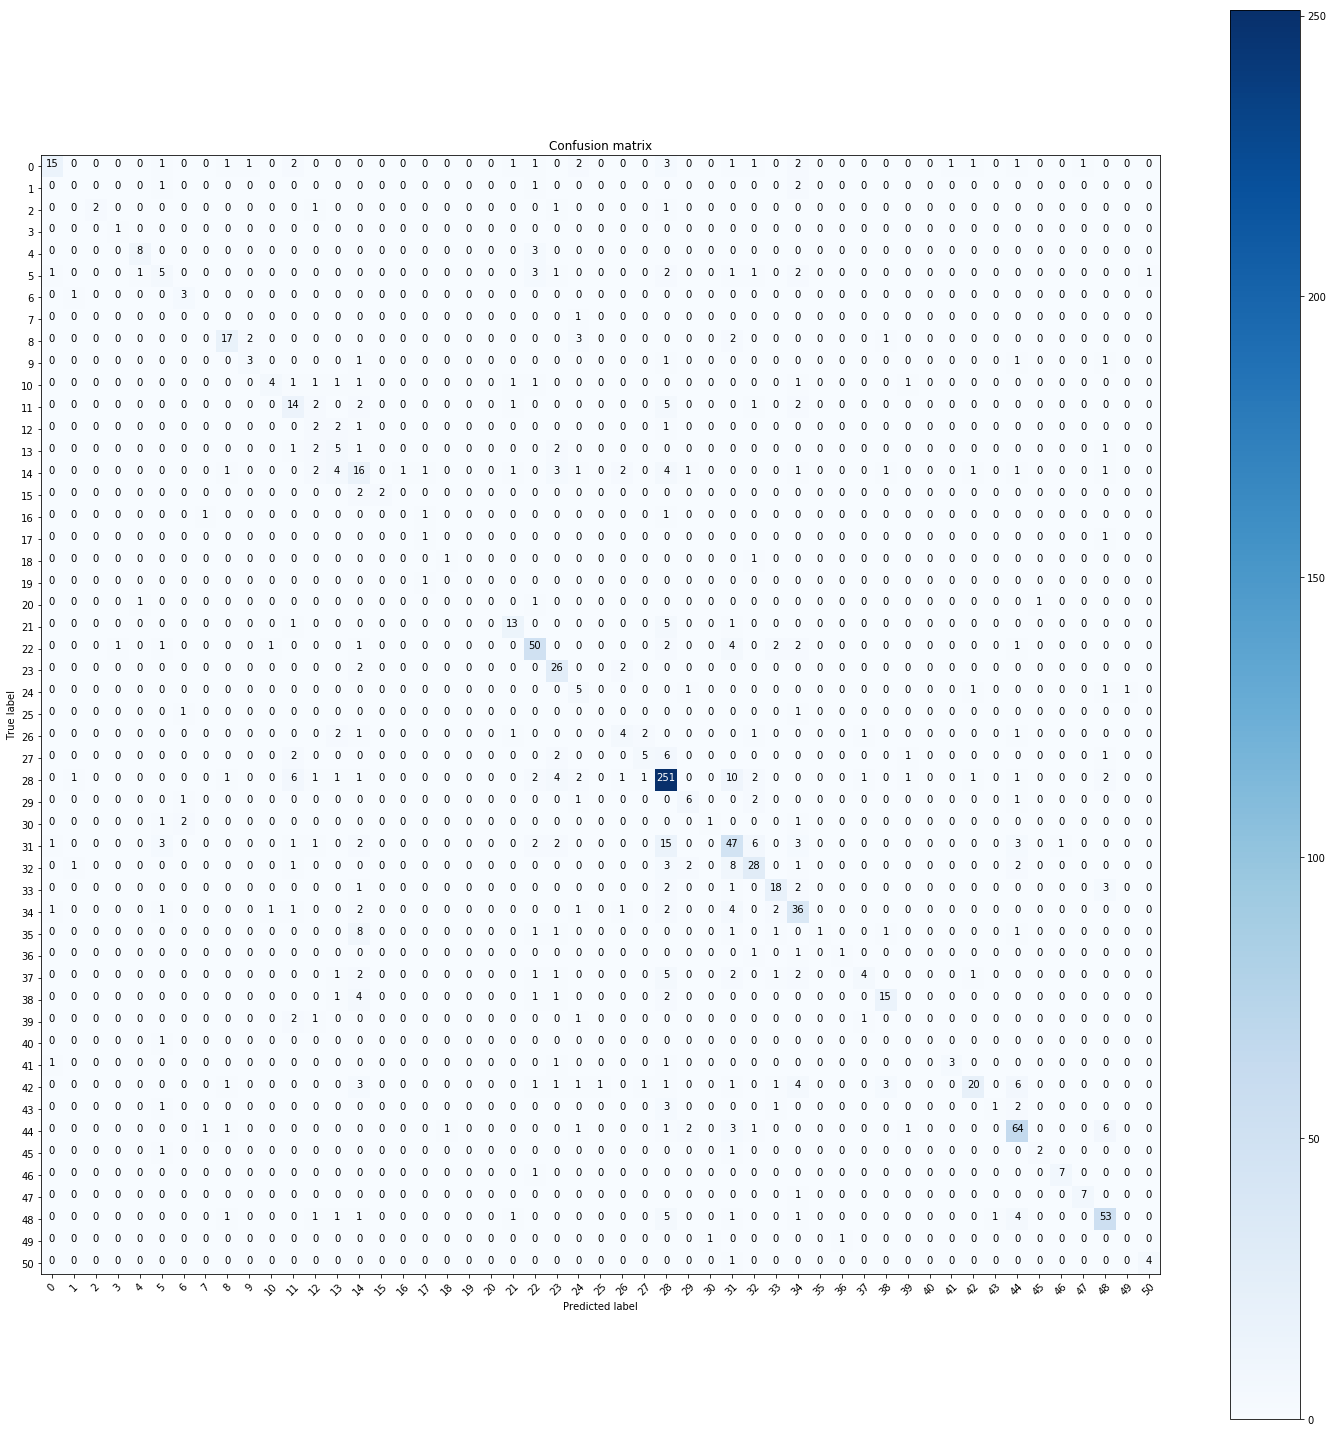

In [66]:
import sklearn
from sklearn.metrics import confusion_matrix

testSequences = tokenizer.texts_to_sequences(XTest['question'])
XEncodedTest = pad_sequences(testSequences, maxlen=sequence_length)
    
YTrue = YTest['intention']
YPredicted = model_lstm.predict_classes(XEncodedTest)
#YPredicted =list(map(lambda x : getHighProbaLabel(x), YProba))

cnf_matrix = confusion_matrix(YTrue, YPredicted)

print(sklearn.metrics.classification_report(YTrue, YPredicted))

plt.figure(figsize=(20,20))

plot_confusion_matrix(cnf_matrix, normalize=False, classes = np.unique(YTrain['intention']))

plt.show()
